# Imports

In [13]:
import functools
import collections
import glob
import itertools
import multiprocessing
import pickle
import re
import os
import sys
import json
from ast import literal_eval

import numpy as onp
import pandas as pd
import plotnine as gg
from ray.tune import Analysis
# import jax.numpy as jnp
# import jax
# import tree

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, '../')

from common.notebook_utils import (
    load_data,
    get_ckpt_paths,
    seed_mavg,
    parse_str_col,
    explode,
    softplus,
)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [156]:
import scipy


def bound_confidence_interval(data, confidence=0.95):
    a = 1.0 * onp.array(data)
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h


def bootstrap_ci_std(df, repetitions=1000):
    bootstrap_sample_size = len(df)
    css = []
    for i in range(repetitions):
        sample = df.sample(n=bootstrap_sample_size, replace=True)
        pgg = sample.to_numpy().std(axis=0)
        css.append(pgg)
    return onp.std(css)

# Gradient comparison

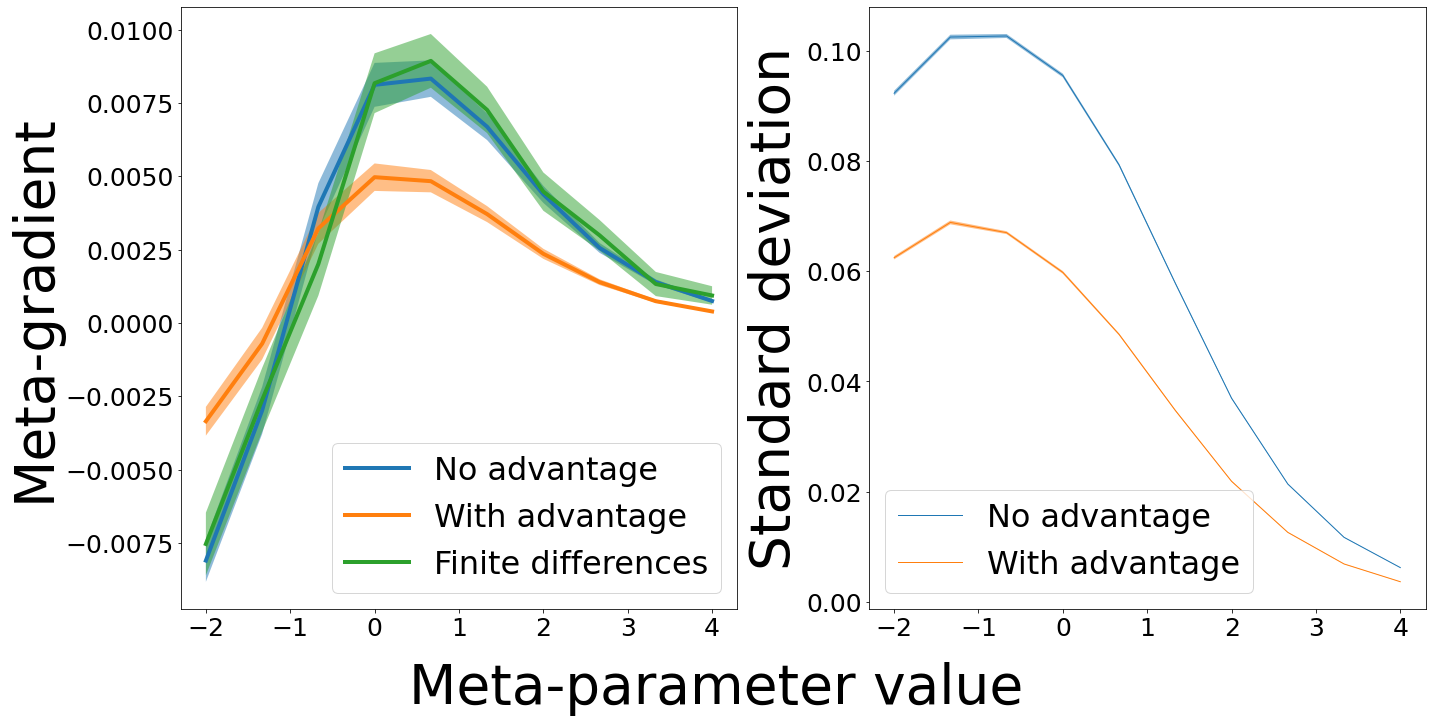

In [183]:
LEGEND_TITLE_FONTSIZE = 35
LEGEND_FONTSIZE = 25
AXIS_LABEL_SIZE = 55
TICK_SIZE = 30






fig, axes = plt.subplots(
    1, 2,
    figsize=(20, 10),
    # sharey=True,
)

ax = onp.array(axes).flatten()[0]
# ax.grid(True)
ax1 = onp.array(axes).flatten()[1]
# ax1.grid(True)
gt = mean_df[
    (mean_df.train_step == 'fd')
    & (mean_df.outer_loss == 'first_state')
].reset_index()
gt_bound = bound_df[
    (mean_df.train_step == 'fd')
    & (mean_df.outer_loss == 'first_state')
].reset_index()
mg_fs_mean = mean_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state')
].reset_index()
mg_fs_bound = bound_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state')
].reset_index()

mg_fsa_mean = mean_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state_adv')
].reset_index()
mg_fsa_bound = bound_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state_adv')
].reset_index()


x = mg_fs_mean.initial_eta
y = mg_fs_mean.grad
bound = mg_fs_bound.grad
ax.plot(x, y, label='No advantage', linewidth=4)
ax.fill_between(
    x, y-bound, y+bound,
    alpha=0.5,
)

x = mg_fsa_mean.initial_eta
y = mg_fsa_mean.grad
bound = mg_fsa_bound.grad
ax.plot(x, y, label='With advantage', linewidth=4)
ax.fill_between(
    x, y-bound, y+bound,
    alpha=0.5,
)

mg_fs_std = std_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state')
].reset_index()
mg_fs_std_ci = mean_std_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state')
].reset_index()
y = mg_fs_std.grad
ci = mg_fs_std_ci.grad
ax1.plot(x, y, label='No advantage', linewidth=4)
ax1.fill_between(
    x, y-ci, y+ci,
    alpha=0.5,
)

mg_fsa_std = std_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state_adv')
].reset_index()
mg_fsa_std_ci = mean_std_df[
    (mean_df.train_step == 'mg')
    & (mean_df.outer_loss == 'first_state_adv')
].reset_index()
y = mg_fsa_std.grad
ci = mg_fsa_std_ci.grad
ax1.plot(x, y, label='With advantage', linewidth=4)
ax1.fill_between(
    x, y-ci, y+ci,
    alpha=0.5,
)

x = gt.initial_eta
y = gt.grad
bound = gt_bound.grad
ax.plot(x, y, label='Finite differences', linewidth=4)
ax.fill_between(
    x, y-bound, y+bound,
    alpha=0.5,
)

ax.legend(
    fontsize=LEGEND_FONTSIZE + 7,
)
ax1.legend(
    fontsize=LEGEND_FONTSIZE + 7,
)
ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE - 5)
ax1.tick_params(axis='both', which='major', labelsize=TICK_SIZE - 5)
ax.set_ylabel('Meta-gradient', fontsize=AXIS_LABEL_SIZE)
ax1.set_ylabel('Standard deviation', fontsize=AXIS_LABEL_SIZE)
fig.supxlabel('Meta-parameter value', fontsize=AXIS_LABEL_SIZE, y=-0.0)
plt.tight_layout()
plt.savefig(f'images/advantage_bias_variance.pdf')